# Handwritten digit Recognition with Keras

*This is a [tutorial](https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/) taken from MachineLearningMastery.com written by Jason Brownlee. Accessed on the 27th Aug 2019*

**Sanket Mehrotra**

Performing this tutorial with a few goals in mind:

        1. How to devlop an effective test harness to develop a robust evaluation of the model and establish a baseline of performance for a classification task
        
        2. How to explore extentions to a baseline model to improve baseline learning and model capacity
        
        3. how to develop a finalized model, evaluate the perfomance of the final model, and use it to make predictions on new images.

In laymans terms:
    
    1. How to load the MNIST dataset in Keras.
    2. How to develop and evaluate a baseline neural network model for the MNIST problem.
    3. How to implement and evaluate a simple Convolutional Neural Network for MNIST.
    4. How to implement a close to state-of-the-art deep learning model for MNIST.


This tutorial is divided into five parts; they are:

    1. MNIST Handwritten Digit Classification Dataset
    2. Model Evaluation Methodology
    3. How to Develop a Baseline Model
    4. How to Develop an Improved Model
    5. How to Finalize the Model and Make Predictions


Train X=(60000, 28, 28), y=(60000,)
Test X=(10000, 28, 28), y=(10000,)


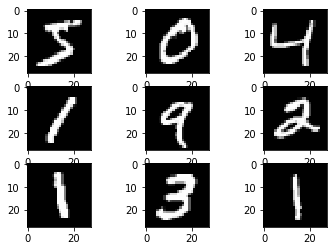

In [3]:
from keras.datasets import mnist
import matplotlib.pyplot as plt

from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD



(trainX,trainY),(testX,testY) = mnist.load_data()

print('Train X=%s, y=%s' % (trainX.shape,trainY.shape))
print('Test X=%s, y=%s' % (testX.shape,testY.shape))

for i in range(9):
    plt.subplot(330+1+i)
    
    plt.imshow(trainX[i],cmap=plt.get_cmap('Greys_r'))
    
    
plt.show()

MNIST stands for the  Modified National Institute for Standards and Technology. It is a dataset of 60,000 28x28 pix greyscale images of handwritten digits between 0-9. 

The task is to classify a given image of a handwritten digit into one fo 10 classes representing integer values from 0-9, inclusively.

Its a widely used dataset and is deeply understood as solved, i.e top performing models are deep learning convolutional networks that achieve a classification accuracy of 99% with an error rate between 0.2% to 0.4% on the test dataset.

We can develop the test-harness in five modular parts so that each can be developed independently and can be switched out for an improved or modified version.


## Load Dataset

In [4]:
def load_data():
    #load dataset
    (trainX,trainY),(testX,testY) = mnist.load_data()

    #reshape dataset to have a single channel
    trainX = trainX.reshape((trainX.shape[0],28,28,1))
    testX = testX.reshape((testX.shape[0],28,28,1))
    #trainX = trainX.reshape(trainX.shape)
    #testX = testX.reshape(testX.shape)

    #one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    
    return trainX,trainY,testX,testY


In [5]:
#1. load the datasets
trainX,trainY,textX,testY = load_data()
    

## Preparing Data

In [6]:
#function to normalize pixel values in each picture so that it is easier to use the data uniformly
def prep_pixels(train,test):
    #int to float
    
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    
    #div by max pixel val 255 to normalize btw 0-1 values
    
    train_norm = train_norm/255.0
    test_norm = test_norm/255.0
    
    return train_norm,test_norm
    
    
    
    
    

## Defining Model

In [7]:
def Define_Model():
    
    #design the model
    model = Sequential()
    
    #CNN with 32 filters of 3x3 
    model.add(Conv2D(32,(3,3),activation='relu',kernel_initializer='he_uniform',input_shape=(28,28,1)))
    #followed by a max pooling layer
    model.add(MaxPooling2D((2,2)))
    #then flatten to add features to the classifier
    model.add(Flatten())
    
    #this layer is a feature extractor layer between the 
    model.add(Dense(100,activation='relu',kernel_initializer='he_uniform'))
    
    #final output layer of 10 classes, will also need a softmax actiation func to normalize the (non-normalized)vector output of the
    #prev layers into a probability distribution between zero and one to map them over the predicted output classes.
    model.add(Dense(10,activation='softmax'))
    
    
    #complile the model
    #keeping the learning rate to 0.01(adjustment rate after each fail)
    #SGD = stochastic gradient descent optimizer
    opt = SGD(lr=0.01,momentum=0.9)
    
    model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
    
    return model


## Evaluating the Model

After designing the model, choosing the appropriate activation functions and setting the constant values for the Stochastic Gradient Descent optimizer, we evaluate the model.

Evaluationg the  model is the stage in which the model is run against smaller sets of the data in a train-test cycle. this is done:
    1. because we don't always have a lot of data, and it's good to make the most of the data we've got. and,
    
    2. in this type of evaluation(cross-validation), the parent training data-set is shuffled before being split so that we can get a similar set of train-test data to train the model on every iteration.

    3. in this tutorial we use a five fold cross-validation method(k=5), this allows the training data set to be divided into roughly 12000 sample-sets (each set 20%) that's close enough to the size of the actual test-data set

we set the model to train for 10 epochs, with 32 examples per batch, the divided sample-sets have their own test-data which will be set against the model to evaluate it's learning after each epoch. We can then plot the learning curve and estimate the performance of the model and the classification accuracy of the model.


In [8]:
def evaluate_model(model,dataX,dataY,n_folds=5):
    scores, histories = list(),list()
    
    kfold = KFold(n_folds,shuffle=True, random_state=1)
    
    for train_ix,test_ix in kfold.split(dataX):
        trainX,trainY,testX,testY = dataX[train_ix],dataY[train_ix],dataX[test_ix],dataY[test_ix]
        
        #fit the model
        print("model.fit Verbose Log starts here:")
        history = model.fit(trainX,trainY,epochs=10,batch_size=32,validation_data=(testX,testY),verbose=1)
        
        print("model.fit Verbose Log ends here.")
        
        print(" model.evaluate Log starts here.")
        acc = model.evaluate(testX,testY,verbose=1)
        print(" model.evaluate Log ends here.")
        
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('> %.3f' % (acc * 100.0))
        
        scores.append(acc)
        histories.append(history)
        
    
    return scores,histories   

## Present Results

The fifth and final part of the tutorial is the presentation of the results. These contain 2 parts:
1. The diagnostics of the learning model
2. The estimation/evaluation of the model perfomance

These can be implemented using 2 diff functions

In [9]:
def summarize_diagnostics(histories):
    for i in range(len(histories)):
        #loss
        plt.subplot(211)
        plt.title('Cross Entropy Loss:')
        plt.plot(histories[i].history['loss'],color='blue',label='train')
        plt.plot(histories[i].history['val_loss'],color='orange',label='test')
        
        #accuracy
        plt.subplot(212)
        plt.title('Classification Accuracy:')
        plt.plot(histories[i].history['acc'],color='blue',label='train')
        plt.plot(histories[i].history['val_acc'],color='orange',label='test')
    plt.show()

In [10]:
def summarize_performance(scores):
    print('Accuracy: mean=%.3f std=%.3f n=%d' % (mean(scores)*100,std(scores)*100,len(scores)))
    
    plt.boxplot(scores)
    plt.show()

And finally the control function: called the Test_Harness


In [11]:
def run_test_harness():
    
    #1. load the datasets
    trainX,trainY,testX,testY = load_data()
    
    #2. prepare the pixel data
    trainX,testX = prep_pixels(trainX,testX)
    
    #3. prepare and design the model
    model = Define_Model()
    
    
    #4. evaluate the model
    scores,histories = evaluate_model(model,trainX,trainY)
    
    #5. summarize/report the performance
    summarize_diagnostics(histories)
    
    summarize_performance(scores)
    
    # save model
    model.save('final_model.h5')
    
    







model.fit Verbose Log starts here:
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 35s 730us/step - loss: 0.1780 - acc: 0.9458 - val_loss: 0.0928 - val_acc: 0.9712
Epoch 2/10
48000/48000 [==============================] - 33s 681us/step - loss: 0.0594 - acc: 0.9821 - val_loss: 0.0657 - val_acc: 0.9798
Epoch 3/10
48000/48000 [==============================] - 33s 688us/step - loss: 0.0375 - acc: 0.9886 - val_loss: 0.0629 - val_acc: 0.9808
Epoch 4/10
48000/48000 [==============================] - 31s 655us/step - loss: 0.0253 - acc: 0.9922 - val_loss: 0.0588 - val_acc: 0.9828
Epoch 5/10
48000/48000 [==============================] - 26s 544us/step - loss: 0.0054 - acc: 0.9991 - val_loss: 0.0575 - val_acc: 0.9848
Epoch 9/10
48000/48000 [==============================] - 26s 546us/step - loss: 0.0038 - acc: 0.9993 - val_loss: 0.058

48000/48000 [==============================] - 30s 631us/step - loss: 4.6669e-04 - acc: 1.0000 - val_loss: 1.0090e-04 - val_acc: 1.0000
Epoch 4/10
48000/48000 [==============================] - 27s 558us/step - loss: 4.6022e-04 - acc: 1.0000 - val_loss: 1.0435e-04 - val_acc: 1.0000
Epoch 5/10
48000/48000 [==============================] - 27s 559us/step - loss: 4.5467e-04 - acc: 1.0000 - val_loss: 1.0280e-04 - val_acc: 1.0000
Epoch 6/10
48000/48000 [==============================] - 27s 559us/step - loss: 4.4978e-04 - acc: 1.0000 - val_loss: 1.0693e-04 - val_acc: 1.0000
Epoch 7/10
48000/48000 [==============================] - 27s 570us/step - loss: 4.4527e-04 - acc: 1.0000 - val_loss: 1.0888e-04 - val_acc: 1.0000
Epoch 8/10
48000/48000 [==============================] - 27s 556us/step - loss: 4.4090e-04 - acc: 1.0000 - val_loss: 1.1231e-04 - val_acc: 1.0000
Epoch 9/10
48000/48000 [==============================] - 26s 547us/step - loss: 4.3694e-04 - acc: 1.0000 - val_loss: 1.1142e-04 

c:\python37\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
c:\python37\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


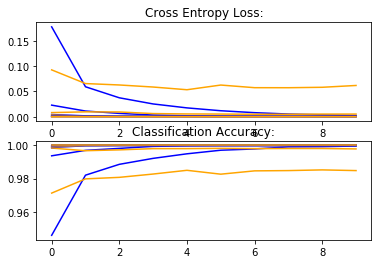

Accuracy: mean=99.655 std=0.591 n=5


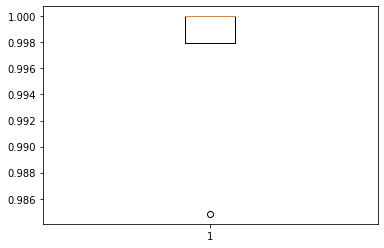

In [12]:
run_test_harness()

## Improving performance with deeper networks

In [ ]:
# deeper cnn model for mnist
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import KFold
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD

# load train and test dataset
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = mnist.load_data()
	# reshape dataset to have a single channel
	trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
	testX = testX.reshape((testX.shape[0], 28, 28, 1))
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY

# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

# evaluate a model using k-fold cross-validation
def evaluate_model(model, dataX, dataY, n_folds=5):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# stores scores
		scores.append(acc)
		histories.append(history)
	return scores, histories

# plot diagnostic learning curves
def summarize_diagnostics(histories):
	for i in range(len(histories)):
		# plot loss
		pyplot.subplot(211)
		pyplot.title('Cross Entropy Loss')
		pyplot.plot(histories[i].history['loss'], color='blue', label='train')
		pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
		# plot accuracy
		pyplot.subplot(212)
		pyplot.title('Classification Accuracy')
		pyplot.plot(histories[i].history['acc'], color='blue', label='train')
		pyplot.plot(histories[i].history['val_acc'], color='orange', label='test')
	pyplot.show()

# summarize model performance
def summarize_performance(scores):
	# print summary
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
	# box and whisker plots of results
	pyplot.boxplot(scores)
	pyplot.show()

# run the test harness for evaluating a model
def run_eval_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX)
	# define model
	model = define_model()
	# evaluate model
	scores, histories = evaluate_model(model, trainX, trainY)
	# learning curves
	summarize_diagnostics(histories)
	# summarize estimated performance
	summarize_performance(scores)
    
def run_fit_test_harness():
    # load dataset
	trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX)
	# define model
	model = define_model()
    # fit model
	model.fit(trainX, trainY, epochs=10, batch_size=32, verbose=0)
	# save model
	model.save('final_model.h5')

# entry point, run the test harness
run_test_harness()

## Prediction - Time

In [ ]:
# make a prediction for a new image.
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model

# load and prepare the image
def load_image(filename):
	# load the image
	img = load_img(filename, grayscale=True, target_size=(28, 28))
	# convert to array
	img = img_to_array(img)
	# reshape into a single sample with 1 channel
	img = img.reshape(1, 28, 28, 1)
	# prepare pixel data
	img = img.astype('float32')
	img = img / 255.0
	return img

# load an image and predict the class
def run_example():
	# load the image
	img = load_image('MNIST_sample_image.png')
	# load model
	model = load_model('final_model.h5')
	# predict the class
	digit = model.predict_classes(img)
	print(digit[0])

# entry point, run the example
run_example()